## <font color = "green"> Exposing <font color = "red">Fake Bills</font>: A Deep Dive into Counterfeit Currency Detection</font>

Counterfeit currency undermines trust in financial institutions and individuals, posing a grave threat to monetary system integrity. **Our project employs data analysis on a dataset of 1,500 bills, aiming to create a reliable system for distinguishing genuine from counterfeit money.** This initiative enhances fraud prevention, bolsters financial security, and fortifies the reliability of our monetary systems.

### Dataset Details

We'll use a dataset of 1500 rows and 7 columns, each row representing a bill with the following attributes:

- **is_genuine** (boolean): This column signifies the bill's authenticity: Genuine (True) or Counterfeit (False).

- **diagonal** (float): Represents bill diagonal measurements in millimeters.

- **height_left** (float): Denotes the left side bill height in millimeters.

- **height_right** (float): Indicates right-side bill height in millimeters.

- **margin_low** (float): Specifies the bill's lower margin in millimeters.

- **margin_upper** (float): Defines the bill's upper margin in millimeters.

- **length** (float): Represents the bill's total length in millimeters.

These attributes are pivotal for our analysis as we explore and predict bill authenticity within the dataset.


## <font color = "blue"> Preliminary Exploratory Data Analysis</font>

In [2]:
# load libraries here
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

#### Reading in the Dataset
For this project, we will be using this [Fake Bills Dataset](https://www.kaggle.com/datasets/alexandrepetit881234/fake-bills) from Kaggle.

In [3]:
bills_data <- read_delim("https://raw.githubusercontent.com/gordnzhou/DSCI-100-project/main/fake_bills.csv", 
                         delim = ";", show_col_types = FALSE )

head(bills_data)

is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TRUE,171.81,104.86,104.95,4.52,2.89,112.83
TRUE,171.46,103.36,103.66,3.77,2.99,113.09
TRUE,172.69,104.48,103.50,4.40,2.94,113.16
TRUE,171.36,103.91,103.94,3.62,3.01,113.51
TRUE,171.73,104.28,103.46,4.04,3.48,112.54
TRUE,172.17,103.74,104.08,4.42,2.95,112.81


### Data Wrangling

The dataset is already tidy with well-formatted variable names. We'll make necessary adjustments for our analysis.

In [4]:
bills_data <- bills_data |>
    mutate(is_genuine = as_factor(is_genuine)) |>
    mutate(is_genuine = fct_recode(is_genuine, "Real" = "TRUE", "Fake" = "FALSE"))
    
head(bills_data)

is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Real,171.81,104.86,104.95,4.52,2.89,112.83
Real,171.46,103.36,103.66,3.77,2.99,113.09
Real,172.69,104.48,103.50,4.40,2.94,113.16
Real,171.36,103.91,103.94,3.62,3.01,113.51
Real,171.73,104.28,103.46,4.04,3.48,112.54
Real,172.17,103.74,104.08,4.42,2.95,112.81


### Summary and Visualization of Training Data

Splitting the data into training and testing subsets:

In [6]:
set.seed(99) # for reproducibility

bills_split <- initial_split(bills_data, prop = 0.75, strata = is_genuine)

bills_train <- training(bills_split)
bills_test <- testing(bills_split)

In the following analysis, we highlight key data features.
- 23 rows with NA values in our training data.
- Mean values for each explanatory variable.
- Out of 1125 training data rows, 375 are `Fake`, and 750 are `Real`, indicating roughly double the data for real bills, a factor to be considered going forward.

In [7]:
na_count <- bills_train |>
    is.na() |>
    sum()
tibble(na_count = na_count)

bills_means <- bills_train |>
    select(diagonal:length) |>
    map_df(mean)
bills_means

bills_count <- bills_train |>
    group_by(is_genuine) |>
    summarize(count = n())
bills_count

na_count
<int>
23


diagonal,height_left,height_right,margin_low,margin_up,length
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
171.9579,104.0248,103.9235,NA,3.152764,112.6745


is_genuine,count
<fct>,<int>
Fake,375
Real,750


We visualized our data with a scatter plot, **using bill length on the x-axis and upper margin_up on the y-axis, both measured in millimeters, and color-coded the points based on authenticity**.

A cluster of fake bills appears in the upper-middle-left, while real bills cluster in the lower-right, indicating shorter bill length and larger upper margin as indicative of fake bills.

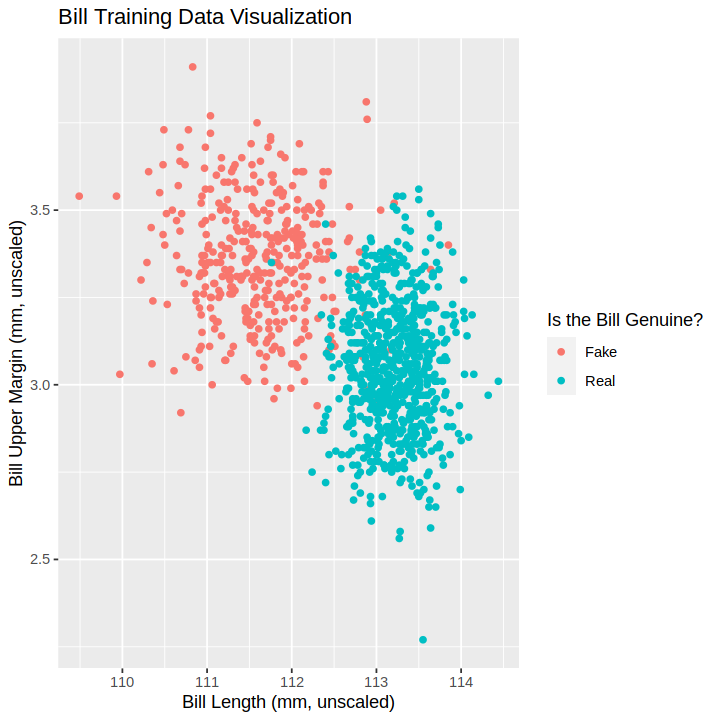

In [8]:
options(repr.plot.width = 6, repr.plot.height = 6)

bills_train_plot <- bills_train |>
    ggplot(aes(x = length, y = margin_up, colour = is_genuine)) +
        ggtitle("Bill Training Data Visualization") +
        geom_point() +
        labs(x = "Bill Length (mm, unscaled)",
             y = "Bill Upper Margin (mm, unscaled)",
             colour = "Is the Bill Genuine?")

bills_train_plot

## <font color = "blue"> Methods</font>

Regarding our explanatory variables, we'll focus on `margin_low`, `margin_right`, and `length`, as they are most relevant to the problem. We also examined `height_left` and `height_right`, but they lack a clear relationship with bill authenticity compared to our primary variables.

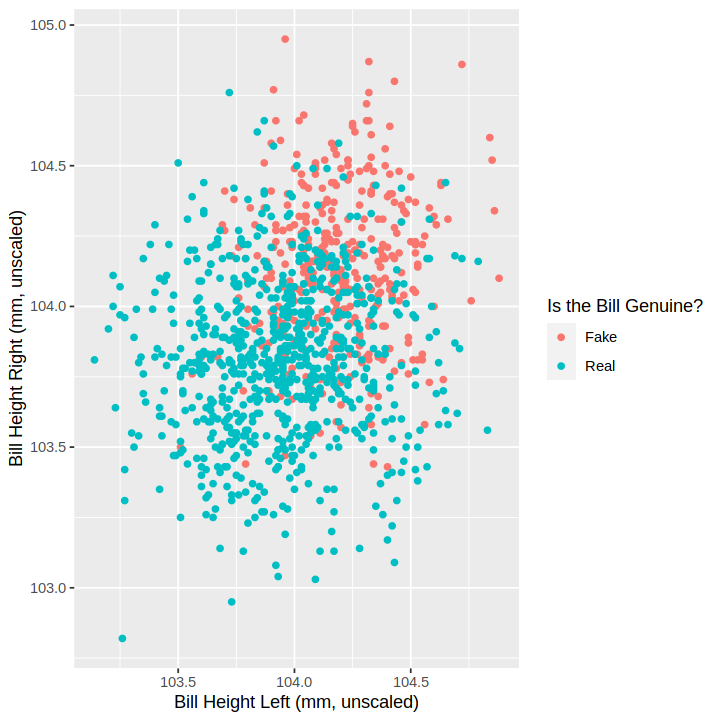

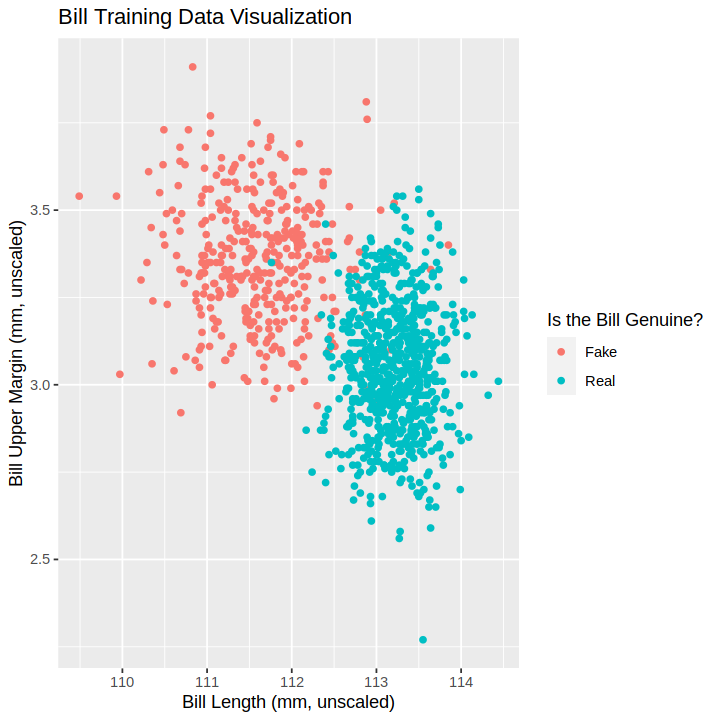

In [9]:
options(repr.plot.width = 6, repr.plot.height = 6)

bills_bad_plot <- bills_train |>
    ggplot(aes(x = height_left, y = height_right, colour = is_genuine)) +
        geom_point() +
        labs(x = "Bill Height Left (mm, unscaled)",
             y = "Bill Height Right (mm, unscaled)",
             colour = "Is the Bill Genuine?")
bills_bad_plot
bills_train_plot

In our analysis, we'll use the **k-Nearest Neighbors (k-NN) classification** algorithm for bill authenticity. **Scaling** will ensure uniformity among variables. **To find the best K, we'll visualize Accuracy vs. K**. After model completion, we'll plot predictor variables and prediction areas to validate our results.

## <font color = "blue"> Expected Outcomes and Significance</font>

**Findings**
- Aim for high accuracy in distinguishing genuine bills from counterfeits using a k-NN classification model.
- Identify key physical attributes (e.g., diagonal measurements, height, margin, length) that drive bill authenticity.

**Significance**
- Enhance the accuracy of differentiating genuine and counterfeit bills, reducing economic losses. 
- Strengthens financial transaction security and user confidence in currency authenticity, fostering more secure monetary transactions.

**Future Questions**
- How can these principles be applied to authenticate currencies globally?
- This project may stimulate advanced authentication methods like sensor technology and machine learning in ATMs and cash handling systems.

**Our project can enhance fraud prevention, financial security, and trust in currency, paving the way for future investigations in currency authentication.**